In [1]:
import tifffile as tif
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

Put data paths here:

In [74]:
path_img = "E:/matteo/2021_05_20/M10/SSp_ul_L_1.tif"
path_params = "E:/matteo/2021_05_20/M10/SSp_ul_L_1.json"

print("Loading data...")
img_stack = tif.imread(path_img)
f = open(path_params, 'r')
data_json = json.load(f)
f.close()
print("Blur and downsample...")
img_stack_blur = np.zeros((img_stack.shape[0],256,256), dtype = np.float64)
for i,frame in enumerate(img_stack):
    img_stack_blur[i] = cv2.resize(cv2.GaussianBlur(frame, (51,51), 0), (256,256), interpolation = cv2.INTER_LINEAR)
print("Done!")

Loading data...
Blur and downsample...
Done!


Extract frame timestamps:

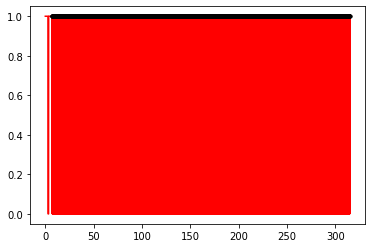

6153 frame timestamps from widefield identified! diff 0.050011 seconds (std 0.000075 s) equivalent to 19.995775 fps
number of frames in widefield: 6186 at 512x512 resolution


In [75]:
data_sync = np.array(data_json["Synchronisation"])
t_sample = data_sync[:,0]   #change this to data_sync[:,0] when using data from sensory_mapping_v2.vi
widefield = data_sync[:,1]  #change this to data_sync[:,1] when using data from sensory_mapping_v2.vi

# convert trigger trace to nice square wave
widefield_thresh = (widefield > 1.5).astype(np.float64)
diff = np.diff(widefield_thresh)

# identify frame timestamps, by averaging timestamps when camera has active exposure
frames = []
sequence = []
for i in range(len(t_sample[1:])):
    if diff[i] == -1:
        sequence = np.array(sequence)
        frames.append(np.mean(sequence[sequence!=0]))
        sequence = []
    sequence.append(widefield_thresh[1:][i]*t_sample[1:][i])

# discard first 2 "frames", which are due to camera starting up, not actual data acquisition    
frames_widefield = np.array(frames[2:])
plt.figure()
plt.plot(t_sample, widefield_thresh, 'r-')
plt.plot(frames_widefield, np.ones(len(frames_widefield)), 'k.')
plt.show()
print("%i frame timestamps from widefield identified!" % len(frames_widefield), end=' ')
print("diff %f seconds (std %f s) equivalent to %f fps" % (np.mean(np.diff(frames_widefield)), np.std(np.diff(frames_widefield)), 1/np.mean(np.diff(frames_widefield))))
print("number of frames in widefield: %i at %ix%i resolution" % (img_stack.shape[0], img_stack.shape[1], img_stack.shape[2]))

fps = round(1/np.mean(np.diff(frames_widefield)))

Compute DF/F of imgages around stimuli onsets:

In [76]:
# determine stimulus type
stim_type = data_json['Stim Type']
print("Stim type is %s." % stim_type)

if stim_type == "Visual":
    stim_timestamps = data_json['Visual Timestamps']
elif stim_type == "Sensory":
    stim_timestamps = data_json['Sensory Timestamps']
elif stim_type == "Auditory":
    stim_timestamps == data_json['Auditory Timestamps']
else:
    raise ValueError("Stim type not recognized!")
    
# make list of DF_F images in +/- 2s range from stim onset
pre_stim = data_json['Pre_stim (s)']
stim_len = data_json['Stimulus Duration (s)']
post_stim = data_json['Post_stim (s)']

frames_pre = int(pre_stim * fps)
frames_stim = int(stim_len * fps)
frames_post = int(post_stim * fps)

DF_F = []

for i in range(len(stim_timestamps)):
    t_onset = stim_timestamps[i]
    frame_onset = np.argwhere(frames_widefield>t_onset)[0][0]
    print("%i/%i, frame %i" % (i+1, len(stim_timestamps), frame_onset))
    before = img_stack_blur[frame_onset-frames_pre:frame_onset,:,:]
    F = np.nanmean(before, axis=0)
    DF_F.append((img_stack_blur[frame_onset-frames_pre:frame_onset+frames_stim+frames_post, :,:]-F)/F)

Stim type is Sensory.
1/30, frame 195
2/30, frame 395
3/30, frame 595
4/30, frame 795
5/30, frame 995
6/30, frame 1195
7/30, frame 1395
8/30, frame 1595
9/30, frame 1795
10/30, frame 1995
11/30, frame 2195
12/30, frame 2395
13/30, frame 2595
14/30, frame 2794
15/30, frame 2994
16/30, frame 3194
17/30, frame 3394
18/30, frame 3594
19/30, frame 3794
20/30, frame 3994
21/30, frame 4194
22/30, frame 4394
23/30, frame 4594
24/30, frame 4794
25/30, frame 4994
26/30, frame 5194
27/30, frame 5394
28/30, frame 5594
29/30, frame 5794
30/30, frame 5994


Compute and plot average DF_F:

(-0.016281357611550796, 0.01414051656685049)

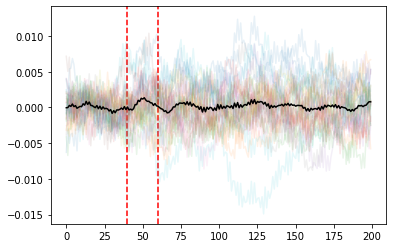

In [77]:
stim_area = data_json["Stimulated brain region"]

img_avg = np.zeros((frames_pre+frames_post+frames_stim,256,256), dtype=np.float64)

plt.figure()
for i in range(len(DF_F)):
    plt.plot(np.nanmean(DF_F[i],axis=(1,2)), alpha=0.1)
    img_avg += DF_F[i]
    
img_avg = img_avg/len(DF_F)
plt.plot(np.nanmean(img_avg, axis=(1,2)), 'k-')
y1,y2 = plt.ylim()
plt.vlines((frames_pre, frames_pre+frames_stim),y1, y2, colors='r', linestyles='dashed')
plt.ylim([y1,y2])

In [78]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
N = frames_pre + frames_stim + frames_post
vmin = np.nanmin(img_avg)
vmax = np.nanmax(img_avg)
@interact
def navigate_stack(i=(0,N,1)):
    plt.imshow(img_avg[i],vmin=vmin, vmax=vmax)
    plt.colorbar()

interactive(children=(IntSlider(value=100, description='i', max=200), Output()), _dom_classes=('widget-interac…

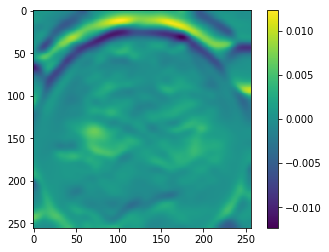

In [79]:
plt.figure()
plt.imshow(np.mean(img_avg[frames_pre:frames_pre+int(fps)], axis=0))
plt.colorbar()

In [14]:
N = frames_pre + frames_stim + frames_post
@interact
def navigate_stack(i=(0,N,1)):
    plt.imshow(img_avg_smooth[i])
    plt.colorbar()


interactive(children=(IntSlider(value=72, description='i', max=144), Output()), _dom_classes=('widget-interact…

In [12]:
frames_pre

40

In [13]:
frame_onset

5994

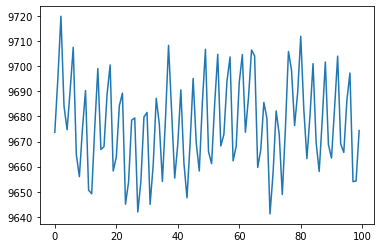

In [62]:
plt.plot(np.mean(img_stack[frame_onset-40:frame_onset+60], axis=(1,2)))